In [1]:
import numpy as np
import pandas as pd
import os
import re
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

#### Extract daily sum and write to csv (already done)

#### Define the read path

In [2]:
hour_path = r'bldf_climate_0'
daily_sum_path = r'bldf_climate_daily'
sobol_file_path = r'sobol_buiding_inputs.csv' 
weather_file_path = r'ZH_standard.csv'

#select_cols = ['cooling_loads', 'dhwLoads', 'heating_loads', 'electricity_loads'] 
target_col = ['cooling_loads'] 

In [3]:
building_hour = {}
building_daily_sum = {}
for file in os.listdir(hour_path):
    if file.endswith('.csv'):
        idx = int(re.findall('\d+',file)[0])
        building_hour[idx] = pd.read_csv(os.path.join(hour_path,file),usecols=target_col)
    
for file in os.listdir(daily_sum_path):
    if file.endswith('.csv'):
        idx = int(re.findall('\d+',file)[0])
        building_daily_sum[idx] = pd.read_csv(os.path.join(daily_sum_path,file),usecols=target_col)
    
building_index = sorted(building_hour.keys())

In [4]:
print(len(building_hour))
print(building_index)

382
[51, 103, 140, 241, 312, 333, 336, 373, 394, 409, 417, 433, 452, 458, 471, 482, 485, 498, 583, 593, 596, 603, 618, 691, 743, 780, 881, 952, 973, 976, 980, 1013, 1034, 1049, 1057, 1073, 1092, 1098, 1111, 1122, 1125, 1138, 1223, 1233, 1236, 1243, 1258, 1293, 1296, 1300, 1333, 1354, 1369, 1377, 1393, 1412, 1418, 1431, 1442, 1445, 1458, 1543, 1553, 1556, 1563, 1578, 1613, 1616, 1620, 1653, 1674, 1689, 1697, 1713, 1732, 1738, 1751, 1762, 1765, 1778, 1863, 1873, 1876, 1883, 1898, 1933, 1936, 1940, 1973, 1994, 2009, 2017, 2033, 2052, 2058, 2071, 2082, 2085, 2098, 2183, 2193, 2196, 2203, 2218, 2253, 2256, 2260, 2293, 2314, 2329, 2337, 2353, 2372, 2378, 2391, 2402, 2405, 2418, 2503, 2513, 2516, 2523, 2538, 2573, 2576, 2580, 2613, 2634, 2649, 2657, 2673, 2692, 2698, 2711, 2722, 2725, 2738, 2823, 2833, 2836, 2843, 2858, 2893, 2896, 2900, 2933, 2954, 2969, 2977, 2993, 3012, 3018, 3031, 3042, 3045, 3058, 3143, 3153, 3156, 3163, 3178, 3213, 3216, 3220, 3253, 3274, 3289, 3297, 3313, 3332, 3338, 3

In [5]:
building_hour[building_index[0]]

,cooling_loads
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8755,0.0
8756,0.0
8757,0.0
8758,0.0


In [6]:
cooling_loads = building_hour[building_index[0]]['cooling_loads']
cooling_loads

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8755    0.0
8756    0.0
8757    0.0
8758    0.0
8759    0.0
Name: cooling_loads, Length: 8760, dtype: float64

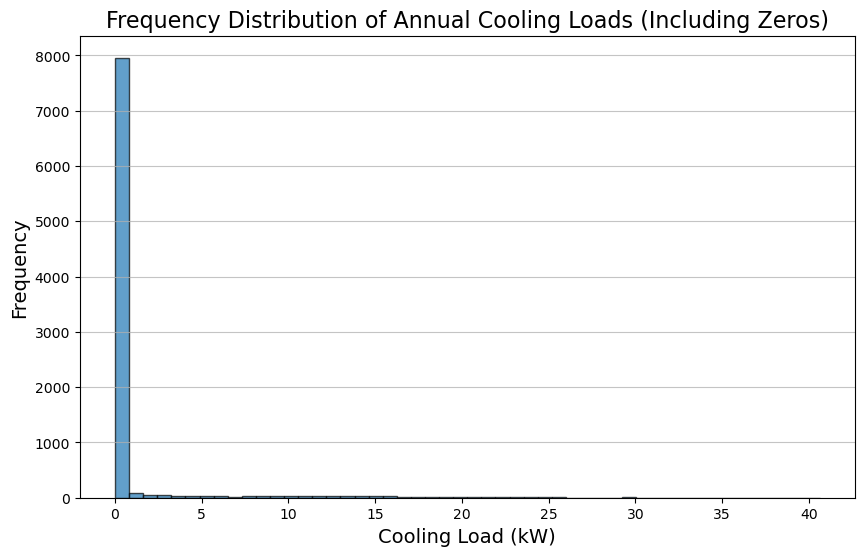

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(cooling_loads, bins=50, edgecolor='black', alpha=0.7)

plt.title('Frequency Distribution of Annual Cooling Loads (Including Zeros)', fontsize=16)
plt.xlabel('Cooling Load (kW)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)

plt.show()

In [8]:
building_daily_sum[building_index[0]]

,cooling_loads
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
360,0.0
361,0.0
362,0.0
363,0.0


In [9]:
weather_columns = [
    'Outside Dry-Bulb Temperature', 
    'Direct Normal Solar', 
    'Diffuse Horizontal Solar'
]
weather = pd.read_csv(weather_file_path,encoding_errors='ignore',usecols=weather_columns).drop(index=0).reset_index(drop=True)
weather

,Outside Dry-Bulb Temperature,Direct Normal Solar,Diffuse Horizontal Solar
0,8.8,0,0
1,8.6,0,0
2,8.4,0,0
3,8.3,0,0
4,8.2,0,0
...,...,...,...
8755,0.2,0,0
8756,-0.1,0,0
8757,-0.3,0,0
8758,-0.5,0,0


In [10]:
sobol_cols = [
    'Ventilation', 'W2WR', 'U-value walls', 'U-value windows',
    'U-value roof', 'U-value floors', 'Infiltration'
]
sobol = pd.read_csv(sobol_file_path,usecols=['1:nfix']+sobol_cols)
sobol.head()

,1:nfix,Ventilation,W2WR,U-value walls,U-value roof,U-value floors,U-value windows,Infiltration
0,1,0.000295,0.837793,0.344121,0.344121,0.344121,1.188463,0.000050
1,2,0.000229,0.595285,0.828834,0.828834,0.828834,2.417690,0.000093
2,3,0.000142,0.485669,0.053773,0.053773,0.053773,1.100675,0.000047
3,4,0.000273,0.332990,0.556044,0.556044,0.556044,1.875587,0.000069
4,5,0.000196,0.648765,1.043078,1.043078,1.043078,1.434067,0.000057


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(3, 3).to(device)
print(f"Tensor device: {x.device}")

Tensor device: cuda:0


In [38]:
torch.manual_seed(2024)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2024)

In [43]:
class ownDataset(Dataset):
    def __init__(self,df1,df2,df3,df4):
        """
        df1: hour series which is a dictionary
        df2: daily sum
        df3: weather(ZH weather series)
        df4: sobol(building related features)
        """
        self.df1 = df1
        self.df2 = df2
        self.df3 = df3
        self.df4 = df4
        self.building_index = list(self.df1.keys())

    def __len__(self):
        return len(self.building_index)
        
    def __getitem__(self,idx):
        index = self.building_index[idx]
        building_daily_sum_feature = torch.tensor(self.df2[index].values,dtype=torch.float)
        building_feature = torch.tensor(self.df4[self.df4["1:nfix"]==index][sobol_cols].values,dtype=torch.float)
        y = torch.tensor(self.df1[index].values,dtype=torch.float).flatten()
        # y = (y - y.mean())/y.std()
        if self.df3 is None:
            # x = torch.cat((building_daily_sum_feature,building_feature.expand(365,-1)),dim=1)
            x = building_daily_sum_feature.flatten()
            #x = torch.cat()
            return x,y
        else:
            weather_feature = torch.tensor(self.df3['Outside Dry-Bulb Temperature'].values,dtype=torch.float)
            #x = torch.cat((building_feature,building_))
            return x,y

data = ownDataset(df1=building_hour,df2=building_daily_sum,df3=None,df4=sobol)
lengths = [int(len(data)*0.8),len(data)-int(len(data)*0.8)]
torch.manual_seed(2024)
train_set,test_set = torch.utils.data.random_split(data,lengths)

train_loader = DataLoader(train_set,batch_size=4,shuffle=True,drop_last=True)
test_loader = DataLoader(test_set,batch_size=4,shuffle=False,drop_last=True)

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break  # 只查看第一个批次

# 获取索引
train_indices = train_set.indices
test_indices = test_set.indices
# 获取建筑物索引
train_building_indices = [data.building_index[i] for i in train_indices]
test_building_indices = [data.building_index[i] for i in test_indices]
print("训练集建筑物索引：", train_building_indices)
print("测试集建筑物索引：", test_building_indices)
print(enumerate(train_loader))

torch.Size([4, 365]) torch.Size([4, 8760])
训练集建筑物索引： [4951, 2954, 3163, 4292, 9201, 2513, 6540, 3289, 7992, 1556, 4978, 3783, 7500, 5361, 1034, 333, 9940, 241, 2098, 3018, 3332, 1933, 7281, 312, 5076, 1431, 6392, 3803, 4458, 3953, 1616, 4436, 3463, 9272, 4103, 2993, 603, 5460, 2692, 7672, 1122, 4443, 1445, 3818, 5811, 5432, 743, 1333, 2071, 2711, 2203, 3253, 7601, 8051, 4173, 3012, 8561, 2418, 1442, 2260, 2900, 2337, 952, 5605, 5618, 10218, 3633, 1296, 3351, 6823, 10085, 4569, 2896, 5223, 336, 3045, 3216, 7783, 1092, 2218, 2372, 7463, 4433, 4554, 10196, 4234, 8423, 1236, 583, 3473, 4249, 1098, 881, 6712, 6771, 5863, 7352, 4002, 10052, 9994, 4938, 2576, 2722, 3153, 3483, 2673, 5900, 4743, 4500, 1393, 5493, 1732, 1898, 452, 51, 5716, 7032, 5591, 2293, 3498, 2253, 3058, 3536, 1258, 4116, 394, 3929, 2738, 2823, 4496, 1778, 5171, 5083, 2893, 471, 6183, 417, 2933, 4962, 4577, 3213, 4257, 1765, 1940, 9521, 5723, 373, 9063, 4325, 4753, 4338, 1354, 7820, 8632, 6961, 5553, 3274, 2183, 4322, 9933

In [44]:
class CoolLoadDenseModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CoolLoadDenseModel, self).__init__()

        # Define the first dense layer to reduce feature dimensions
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        
        # Define additional dense layers to create a deep network
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(0.2))

        # Define the final output layer
        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        # Pass through the hidden dense layers
        for layer in self.hidden_layers:
            x = layer(x)

        # Pass through the output layer
        # output = F.softplus(self.fc_out(x))
        output = self.fc_out(x)
        return output

# Example usage:
input_size = 365 # daily energy
hidden_sizes = [128, 256, 512]  # Hidden layer sizes for a deep dense network
output_size = 8760  # Predict hourly cooling load

# Instantiate the model
feedforward = CoolLoadDenseModel(input_size, hidden_sizes, output_size)

# Print the model architecture
print(feedforward)

CoolLoadDenseModel(
  (fc1): Linear(in_features=365, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (fc_out): Linear(in_features=512, out_features=8760, bias=True)
)


In [45]:
class myNet(nn.Module):
    def __init__(self):
        super(myNet,self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=8,nhead=8,batch_first=True)
        self.fc1 = nn.Linear(365*8,4096)
        self.fc2 = nn.Linear(4096,8760)
        
    def forward(self,x):
        out = self.encoder(x)
        out = out.view(-1,365*8)
        out = F.relu(self.fc1(out))
        # out = F.relu(self.fc2(out))
        out = self.fc2(out)
        return out

In [46]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super(PositionalEmbedding, self).__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1) # (batch_size, max_len, d_model)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias


class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn 
        # attention (batch_size, heads, seq_len_q, d_v)
        # attention weight (batch_size, heads, seq_len_k, d_v)


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(
            query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(
            batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        # self.activation = GELU()

    def forward(self, x):
        return self.w_2(F.gelu(self.w_1(x)))


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.layer_norm(x + self.dropout(sublayer(x)))


class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(
            h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(
            d_model=hidden, d_ff=feed_forward_hidden)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(
            x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


class BERT4NILM(nn.Module):
    def __init__(self):
        super().__init__()

        self.original_len = 365
        self.latent_len = int(self.original_len/2)
        self.dropout_rate = 0.1

        self.hidden = 256
        self.heads = 2
        self.n_layers = 2
        self.output_size = 24
        
        self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                               kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        self.layer_norm = LayerNorm(self.hidden)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(
            self.hidden, self.heads, self.hidden * 4, self.dropout_rate) for _ in range(self.n_layers)])

        self.deconv = nn.ConvTranspose1d(
            in_channels=self.hidden, out_channels=self.hidden, kernel_size=4, stride=2, padding=1,output_padding=1)
        self.linear1 = nn.Linear(self.hidden, 128)
        self.linear2 = nn.Linear(128, self.output_size)

    def forward(self, sequence):
        # print("sequence",sequence.shape)
        x_token = self.pool(self.conv(sequence.unsqueeze(1))).permute(0, 2, 1)
        # print("x_token",x_token.shape)
        embedding = x_token + self.position(sequence)
        x = self.dropout(self.layer_norm(embedding))

        mask = None
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.deconv(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x.flatten(start_dim=1)

In [47]:
def train(model, loader1, loader2, optimizer, criterion, num_epoch=1600): 
    model.train()
    print('Starting....')
    train_lss = []
    test_lss = []
    for epoch in range(num_epoch):
        train_loss = 0
        idx = 0
        for i,(seq_in,seq_out) in enumerate(loader1):
            seq_in = seq_in.to(device)       # 将输入数据移动到设备
            seq_out = seq_out.to(device)     # 将目标数据移动到设备
            optimizer.zero_grad()
            out = model(seq_in)
            loss = criterion(out,seq_out)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # idx += 1
        # train_loss /= idx
        train_loss /= (i+1)
        train_lss.append(train_loss)
        
        test_loss = test(model, loader2, criterion)
        test_lss.append(test_loss)
        if epoch%5==0:
            print(f'Epoch {epoch},training loss is {train_loss:.4f}, testing loss is {test_loss:.4f}')
    return train_lss,test_lss

def test(model, loader, criterion): 
    total_loss = 0
    model.eval()
    idx = 0
    with torch.no_grad():
        for i,(seq_in,seq_out) in enumerate(loader):
            seq_in = seq_in.to(device)       # 将输入数据移动到设备
            seq_out = seq_out.to(device)     # 将目标数据移动到设备
            out = model(seq_in)
            loss = criterion(out,seq_out)
            total_loss += loss.item()
        #     idx += 1
        # total_loss /= idx
        total_loss /= (i+1)
    return total_loss  

In [48]:
# **定义损失函数和优化器（移出 train 函数）**
model = feedforward
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_MLP, test_MLP = train(model, train_loader, test_loader, optimizer, criterion)

Starting....
Epoch 0,training loss is 64.0815, testing loss is 55.3565
Epoch 5,training loss is 4.4997, testing loss is 3.8453
Epoch 10,training loss is 3.3776, testing loss is 3.0023
Epoch 15,training loss is 2.6645, testing loss is 2.6001
Epoch 20,training loss is 2.4874, testing loss is 2.2017
Epoch 25,training loss is 2.1649, testing loss is 2.1778
Epoch 30,training loss is 1.9650, testing loss is 1.8397
Epoch 35,training loss is 1.8086, testing loss is 1.7300
Epoch 40,training loss is 1.6113, testing loss is 1.5386
Epoch 45,training loss is 1.5284, testing loss is 1.5476
Epoch 50,training loss is 1.3575, testing loss is 1.3669
Epoch 55,training loss is 1.2702, testing loss is 1.5871
Epoch 60,training loss is 1.2040, testing loss is 1.2365
Epoch 65,training loss is 1.2088, testing loss is 1.3313
Epoch 70,training loss is 1.2238, testing loss is 1.4369
Epoch 75,training loss is 1.0834, testing loss is 1.1423
Epoch 80,training loss is 1.0386, testing loss is 1.1027
Epoch 85,training 

cuda:0


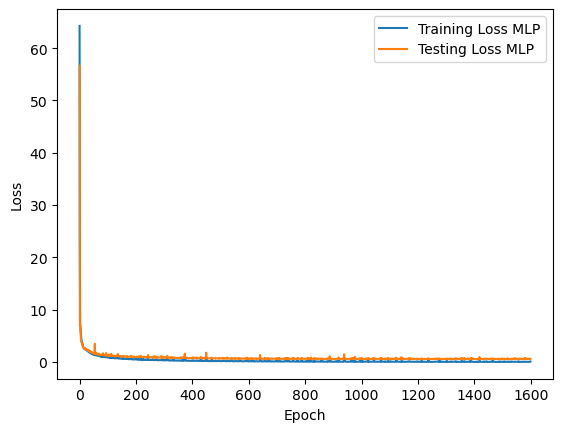

In [27]:
print(next(model.parameters()).device)
plt.plot(train_MLP, label='Training Loss MLP')
plt.plot(test_MLP, label='Testing Loss MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# 假设 feedforward 是您的模型实例
torch.save(feedforward.state_dict(), 'feedforward.pth')
print("Model saved successfully.")

Model saved successfully.


In [33]:
model = myNet()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_encoder, test_encoder = train(model, train_loader, test_loader, optimizer, criterion)

Starting....


C:\Users\reise\anaconda3\envs\24sp\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 0,training loss is 38.5824, testing loss is 14.6584
Epoch 5,training loss is 13.4067, testing loss is 7.8184
Epoch 10,training loss is 10.7011, testing loss is 7.3747
Epoch 15,training loss is 6.1506, testing loss is 6.6148
Epoch 20,training loss is 4.4791, testing loss is 4.9262
Epoch 25,training loss is 3.6969, testing loss is 4.7120
Epoch 30,training loss is 3.4406, testing loss is 5.3892
Epoch 35,training loss is 2.7530, testing loss is 4.1761
Epoch 40,training loss is 2.9262, testing loss is 4.1417
Epoch 45,training loss is 2.4506, testing loss is 3.9326
Epoch 50,training loss is 2.2363, testing loss is 3.8172
Epoch 55,training loss is 1.6912, testing loss is 5.1934
Epoch 60,training loss is 1.8347, testing loss is 3.5311
Epoch 65,training loss is 1.4070, testing loss is 3.4320
Epoch 70,training loss is 1.1549, testing loss is 3.3964
Epoch 75,training loss is 1.1291, testing loss is 3.2590
Epoch 80,training loss is 1.2473, testing loss is 3.3996
Epoch 85,training loss is 1.1

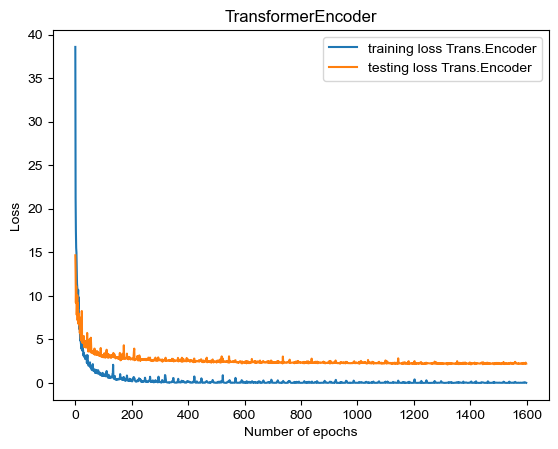

In [56]:
plt.plot(train_encoder,label='training loss Trans.Encoder')
plt.plot(test_encoder,label='testing loss Trans.Encoder')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('TransformerEncoder')
plt.legend()
plt.show()

In [77]:
torch.save(model.state_dict(), 'myNet_model.pth')
print("myNet model saved successfully.")

myNet model saved successfully.


In [30]:
model = BERT4NILM()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_bert, test_bert = train(model, train_loader, test_loader, optimizer, criterion)

Starting....
Epoch 0,training loss is 62.5872, testing loss is 56.2595
Epoch 5,training loss is 50.6336, testing loss is 46.1359
Epoch 10,training loss is 43.7623, testing loss is 39.5422
Epoch 15,training loss is 38.5641, testing loss is 34.7642
Epoch 20,training loss is 34.5358, testing loss is 30.9472
Epoch 25,training loss is 31.3433, testing loss is 27.7177
Epoch 30,training loss is 28.8821, testing loss is 25.8095
Epoch 35,training loss is 26.2211, testing loss is 23.1992
Epoch 40,training loss is 24.2796, testing loss is 21.2039
Epoch 45,training loss is 22.6076, testing loss is 19.6980
Epoch 50,training loss is 21.0718, testing loss is 18.2129
Epoch 55,training loss is 18.6213, testing loss is 17.2310
Epoch 60,training loss is 18.5905, testing loss is 16.0362
Epoch 65,training loss is 17.4509, testing loss is 15.0262
Epoch 70,training loss is 16.6506, testing loss is 14.1785
Epoch 75,training loss is 15.5658, testing loss is 13.3036
Epoch 80,training loss is 15.0700, testing lo

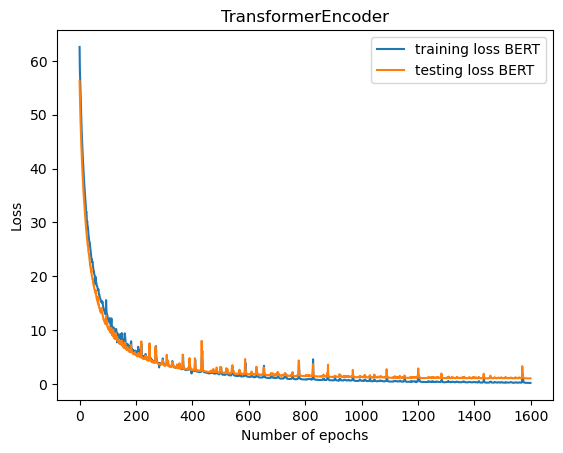

In [36]:
plt.plot(train_bert,label='training loss BERT')
plt.plot(test_bert,label='testing loss BERT')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('TransformerEncoder')
plt.legend()
plt.show()

In [78]:
torch.save(model.state_dict(), 'BERT4NILM_model.pth')
print("BERT4NILM model saved successfully.")

BERT4NILM model saved successfully.


In [41]:
import pickle

# 保存训练损失
with open('train_MLP.pkl', 'wb') as f:
    pickle.dump(train_MLP, f)
with open('test_MLP.pkl', 'wb') as f:
    pickle.dump(test_MLP, f)

with open('train_encoder.pkl', 'wb') as f:
    pickle.dump(train_encoder, f)
with open('test_encoder.pkl', 'wb') as f:
    pickle.dump(test_encoder, f)

with open('train_bert.pkl', 'wb') as f:
    pickle.dump(train_bert, f)
with open('test_bert.pkl', 'wb') as f:
    pickle.dump(test_bert, f)

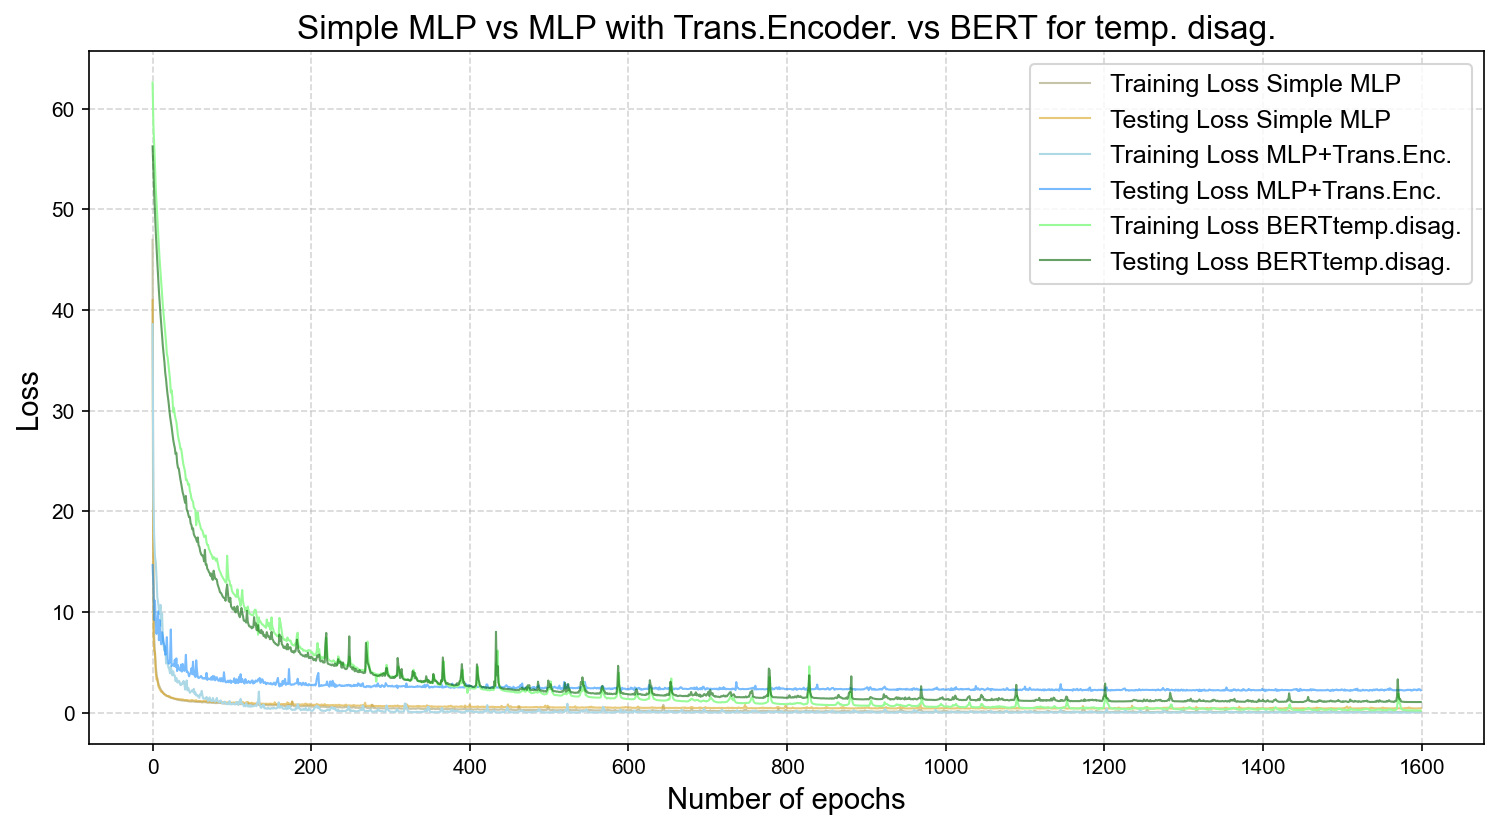

In [67]:
import matplotlib.pyplot as plt

# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 设置图形尺寸和分辨率
plt.figure(figsize=(12, 6), dpi=150)  # 更宽的图形，分辨率为150

# 定义颜色方案，增加对比度
colors = {
    'MLP': {'train': '#c7c4a9', 'test': '#DAA520'},                 # 浅黄色和深黄色
    'TransformerEncoder': {'train': '#ADD8E6', 'test': '#1E90FF'},   # 浅蓝色和深蓝色
    'BERT': {'train': '#98FB98', 'test': '#006400'}                # 浅绿色和深绿色
}

# 定义线宽
line_width = 1

# 绘制MLP的训练和测试损失曲线
plt.plot(train_MLP, label='Training Loss Simple MLP', color=colors['MLP']['train'], linestyle='-', linewidth=line_width)
plt.plot(test_MLP, label='Testing Loss Simple MLP', color=colors['MLP']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 绘制Transformer Encoder的训练和测试损失曲线
plt.plot(train_encoder, label='Training Loss MLP+Trans.Enc.', color=colors['TransformerEncoder']['train'], linestyle='-', linewidth=line_width)
plt.plot(test_encoder, label='Testing Loss MLP+Trans.Enc.', color=colors['TransformerEncoder']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 绘制BERT的训练和测试损失曲线
plt.plot(train_bert, label='Training Loss BERTtemp.disag.', color=colors['BERT']['train'], linestyle='-', linewidth=line_width)
plt.plot(test_bert, label='Testing Loss BERTtemp.disag.', color=colors['BERT']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 设置坐标轴标签和标题
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Simple MLP vs MLP with Trans.Encoder. vs BERT for temp. disag.', fontsize=16)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.5)

# 显示图例，并设置字体大小
plt.legend(loc='best', fontsize=12)

# 如果需要保存图像，可以使用以下代码
plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

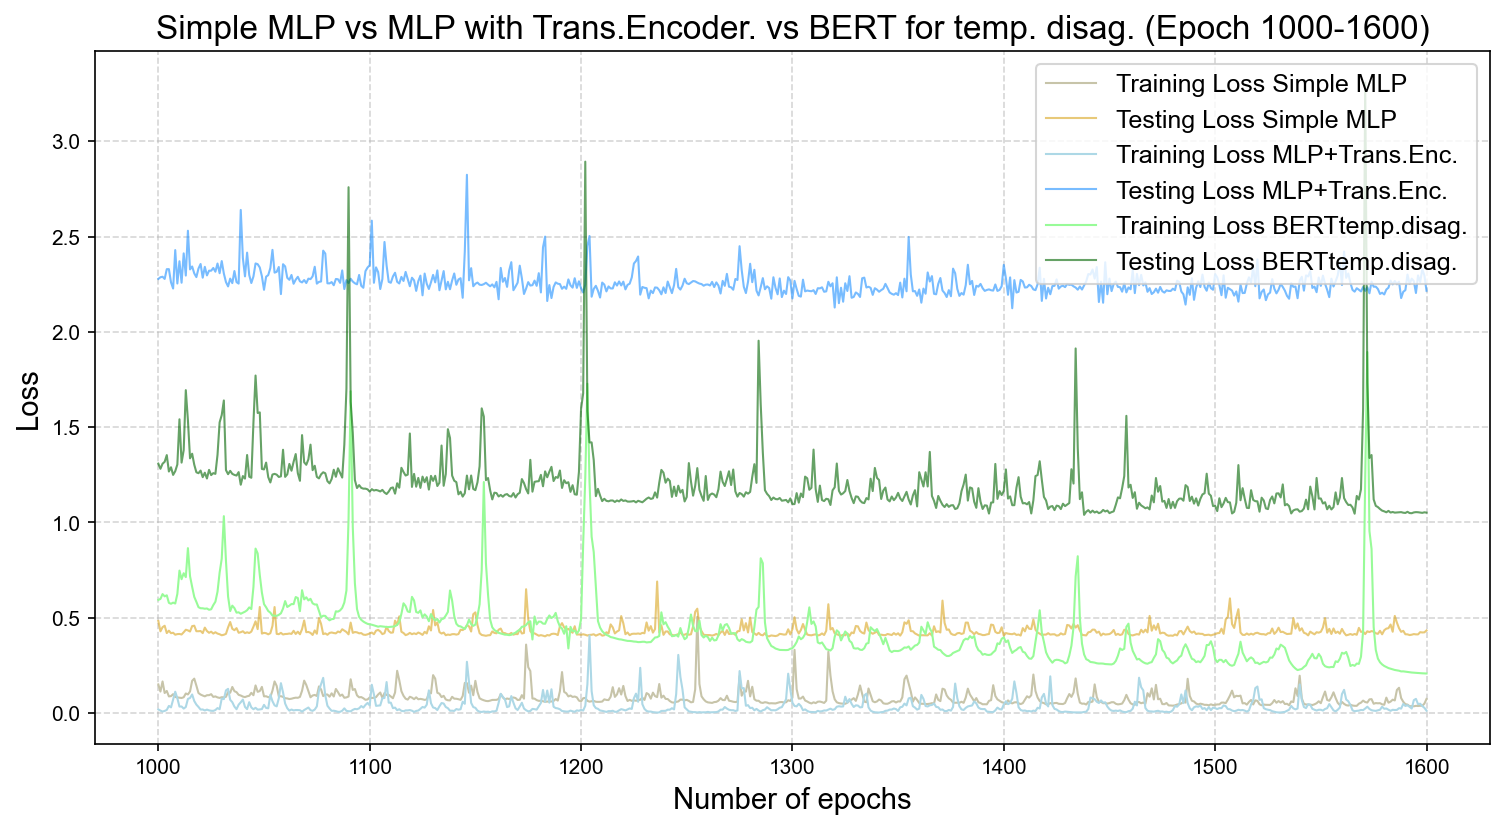

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# 假设已经定义并训练了以下损失列表
# train_MLP, test_MLP = ...
# train_encoder, test_encoder = ...
# train_bert, test_bert = ...

# 定义开始和结束epoch
start_epoch = 1000
end_epoch = 1600

# 切取数据（Python索引从0开始，因此1000-1=999）
train_MLP_subset = train_MLP[start_epoch-1:end_epoch]
test_MLP_subset = test_MLP[start_epoch-1:end_epoch]

train_encoder_subset = train_encoder[start_epoch-1:end_epoch]
test_encoder_subset = test_encoder[start_epoch-1:end_epoch]

train_bert_subset = train_bert[start_epoch-1:end_epoch]
test_bert_subset = test_bert[start_epoch-1:end_epoch]

# 创建x轴数据
epochs = np.arange(start_epoch, end_epoch + 1)

# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 设置图形尺寸和分辨率
plt.figure(figsize=(12, 6), dpi=150)  # 更宽的图形，分辨率为150

# 定义颜色方案，增加对比度
colors = {
    'MLP': {'train': '#c7c4a9', 'test': '#DAA520'},                 # 浅黄色和深黄色
    'TransformerEncoder': {'train': '#ADD8E6', 'test': '#1E90FF'},   # 浅蓝色和深蓝色
    'BERT': {'train': '#98FB98', 'test': '#006400'}                # 浅绿色和深绿色
}

# 定义线宽
line_width = 1

# 绘制MLP的训练和测试损失曲线
plt.plot(epochs, train_MLP_subset, label='Training Loss Simple MLP', color=colors['MLP']['train'], linestyle='-', linewidth=line_width)
plt.plot(epochs, test_MLP_subset, label='Testing Loss Simple MLP', color=colors['MLP']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 绘制Transformer Encoder的训练和测试损失曲线
plt.plot(epochs, train_encoder_subset, label='Training Loss MLP+Trans.Enc.', color=colors['TransformerEncoder']['train'], linestyle='-', linewidth=line_width)
plt.plot(epochs, test_encoder_subset, label='Testing Loss MLP+Trans.Enc.', color=colors['TransformerEncoder']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 绘制BERT的训练和测试损失曲线
plt.plot(epochs, train_bert_subset, label='Training Loss BERTtemp.disag.', color=colors['BERT']['train'], linestyle='-', linewidth=line_width)
plt.plot(epochs, test_bert_subset, label='Testing Loss BERTtemp.disag.', color=colors['BERT']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 设置坐标轴标签和标题
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Simple MLP vs MLP with Trans.Encoder. vs BERT for temp. disag. (Epoch 1000-1600)', fontsize=16)

# 设置x轴刻度间隔
plt.xticks(np.arange(start_epoch, end_epoch + 1, 100))

# 添加网格线，调整样式
plt.grid(True, linestyle='--', alpha=0.5)

# 显示图例，并设置字体大小
plt.legend(loc='best', fontsize=12)

# 如果需要保存图像，可以使用以下代码
plt.savefig('loss_plot_epoch1000_1600.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

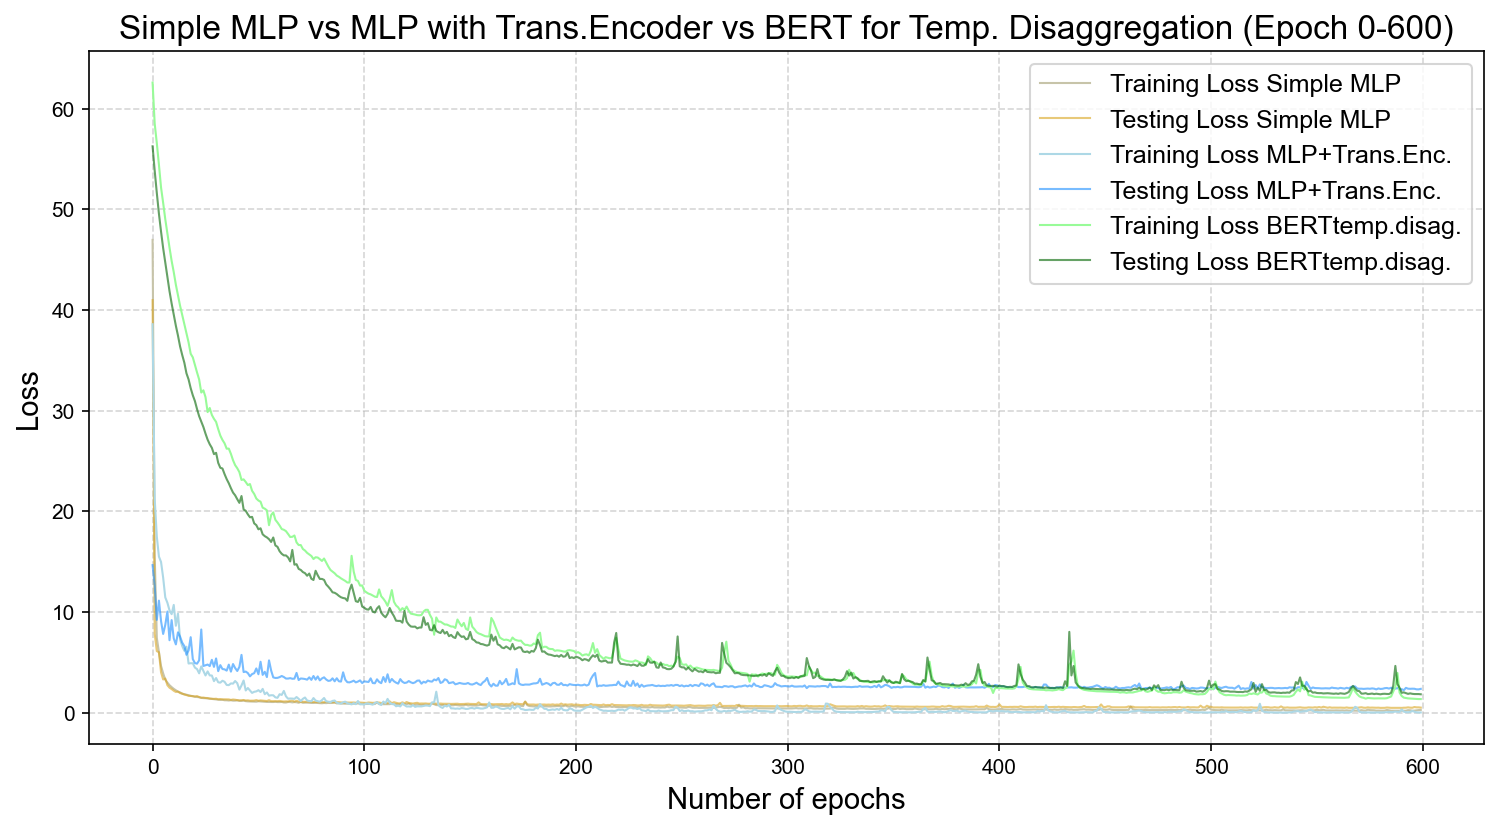

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# 定义开始和结束epoch
start_epoch = 0
end_epoch = 600

# 切取数据（Python索引从0开始，因此epoch 0对应索引0，epoch 600对应索引600）
train_MLP_subset = train_MLP[start_epoch:end_epoch]
test_MLP_subset = test_MLP[start_epoch:end_epoch]

train_encoder_subset = train_encoder[start_epoch:end_epoch]
test_encoder_subset = test_encoder[start_epoch:end_epoch]

train_bert_subset = train_bert[start_epoch:end_epoch]
test_bert_subset = test_bert[start_epoch:end_epoch]

# 创建x轴数据
epochs = np.arange(start_epoch, end_epoch)

# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial'

# 设置图形尺寸和分辨率
plt.figure(figsize=(12, 6), dpi=150)  # 宽12英寸，高6英寸，分辨率150 dpi

# 定义颜色方案，增加对比度
colors = {
    'MLP': {'train': '#c7c4a9', 'test': '#DAA520'},                 # 浅黄色和深黄色
    'TransformerEncoder': {'train': '#ADD8E6', 'test': '#1E90FF'},   # 浅蓝色和深蓝色
    'BERT': {'train': '#98FB98', 'test': '#006400'}                # 浅绿色和深绿色
}

# 定义线宽
line_width = 1

# 绘制MLP的训练和测试损失曲线
plt.plot(epochs, train_MLP_subset, label='Training Loss Simple MLP',
         color=colors['MLP']['train'], linestyle='-', linewidth=line_width)
plt.plot(epochs, test_MLP_subset, label='Testing Loss Simple MLP',
         color=colors['MLP']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 绘制Transformer Encoder的训练和测试损失曲线
plt.plot(epochs, train_encoder_subset, label='Training Loss MLP+Trans.Enc.',
         color=colors['TransformerEncoder']['train'], linestyle='-', linewidth=line_width)
plt.plot(epochs, test_encoder_subset, label='Testing Loss MLP+Trans.Enc.',
         color=colors['TransformerEncoder']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 绘制BERT的训练和测试损失曲线
plt.plot(epochs, train_bert_subset, label='Training Loss BERTtemp.disag.',
         color=colors['BERT']['train'], linestyle='-', linewidth=line_width)
plt.plot(epochs, test_bert_subset, label='Testing Loss BERTtemp.disag.',
         color=colors['BERT']['test'], linestyle='-', linewidth=line_width, alpha=0.6)

# 设置坐标轴标签和标题
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Simple MLP vs MLP with Trans.Encoder vs BERT for Temp. Disaggregation (Epoch 0-600)', fontsize=16)

# 添加网格线，调整样式
plt.grid(True, linestyle='--', alpha=0.5)

# 设置x轴刻度间隔
plt.xticks(np.arange(start_epoch, end_epoch + 1, 100))

# 显示图例，并设置字体大小
plt.legend(loc='best', fontsize=12)

# 保存图像
plt.savefig('loss_plot_epoch0_600.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

Running prediction for building index: 1973


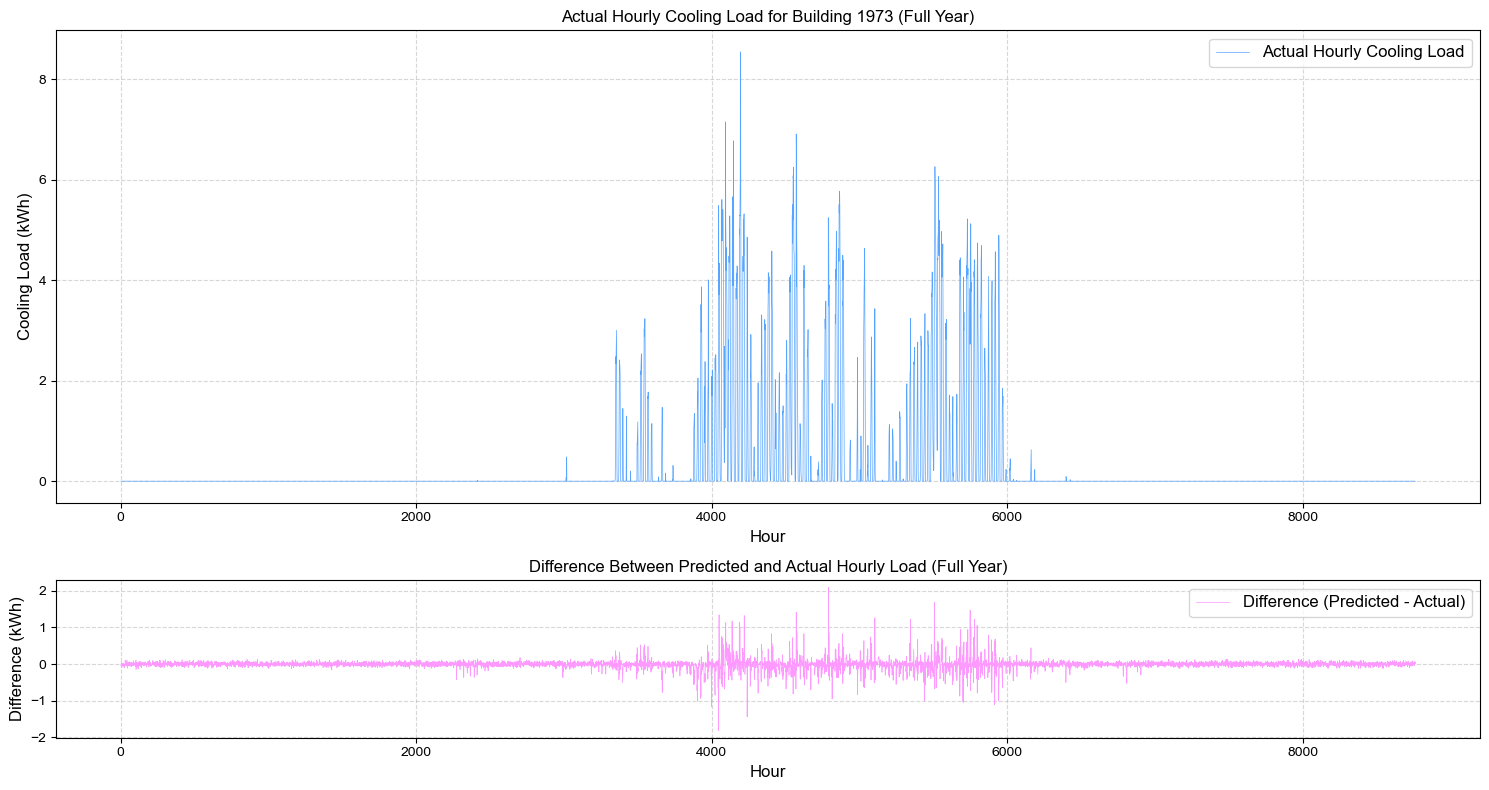

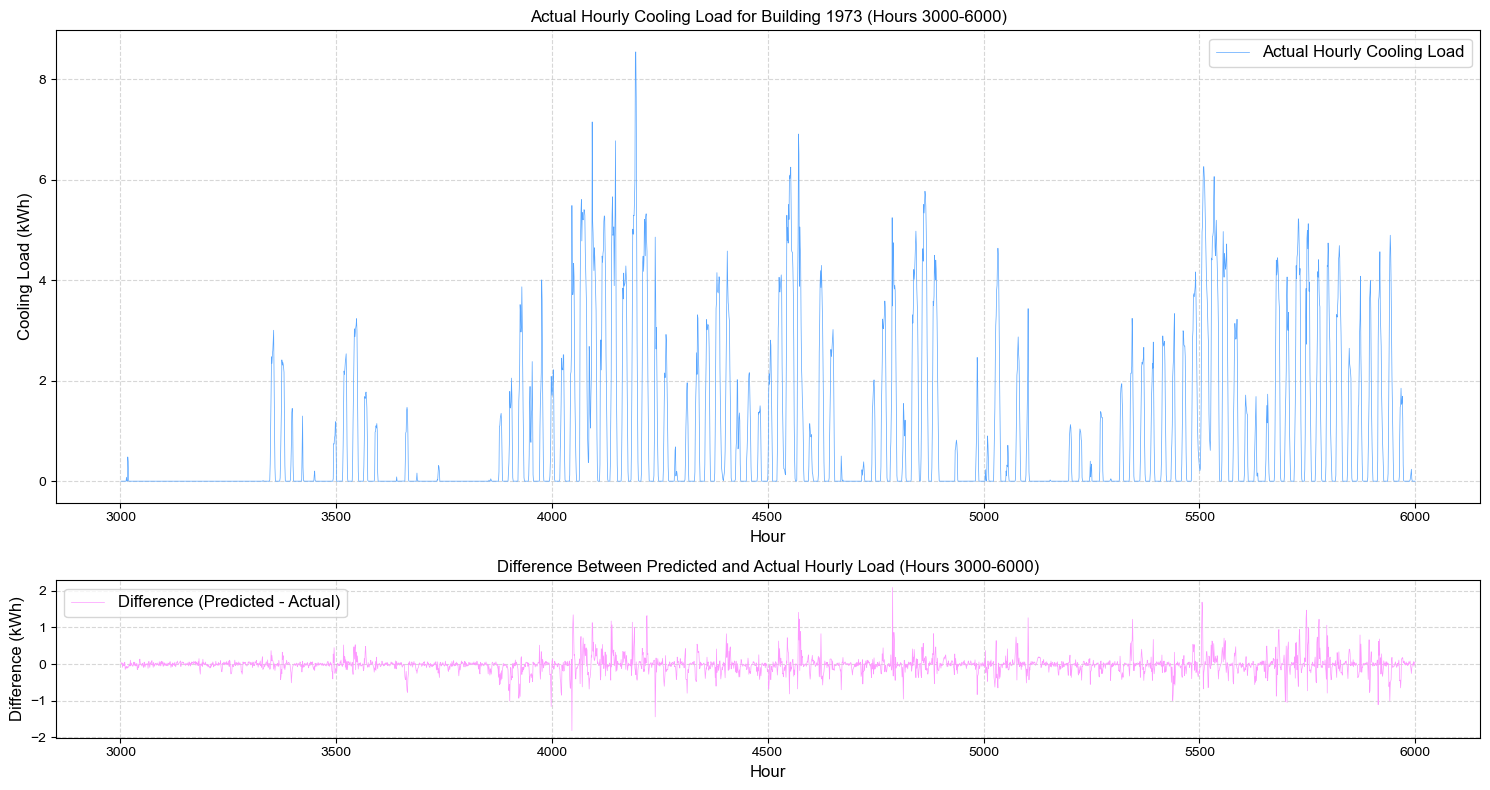

In [61]:
import os
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class BuildingLoadPredictor:
    def __init__(self, model, hour_path, daily_sum_path, target_col):
        """
        Initialize the predictor.

        Parameters:
        - model: The trained model (e.g., a PyTorch model)
        - hour_path: Directory containing hourly load data
        - daily_sum_path: Directory containing daily load data
        - target_col: List of target column names (e.g., ['cooling_loads'])
        """
        self.model = model
        self.hour_path = hour_path
        self.daily_sum_path = daily_sum_path
        self.target_col = target_col

    def load_building_data(self, building_idx):
        """
        Load daily and hourly load data for a specific building.

        Parameters:
        - building_idx: Building index

        Returns:
        - daily_load: NumPy array of shape (365,)
        - actual_hourly_load: NumPy array of shape (8760,)
        """
        hour_file = os.path.join(self.hour_path, f'building_input_{building_idx}.csv')
        daily_file = os.path.join(self.daily_sum_path, f'building_input_{building_idx}_daily_sum.csv')

        if not os.path.exists(hour_file):
            raise FileNotFoundError(f"Hourly load data file for building {building_idx} does not exist: {hour_file}")
        if not os.path.exists(daily_file):
            raise FileNotFoundError(f"Daily load data file for building {building_idx} does not exist: {daily_file}")

        # Load data
        hourly_load_df = pd.read_csv(hour_file, usecols=self.target_col)
        daily_load_df = pd.read_csv(daily_file, usecols=self.target_col)

        # Check data length
        if len(daily_load_df) != 365:
            raise ValueError(f"Daily load data for building {building_idx} does not have 365 days. Actual: {len(daily_load_df)} days.")
        if len(hourly_load_df) != 8760:
            raise ValueError(f"Hourly load data for building {building_idx} does not have 8760 hours. Actual: {len(hourly_load_df)} hours.")

        # Extract data
        daily_load = daily_load_df[self.target_col[0]].values  # Shape: (365,)
        actual_hourly_load = hourly_load_df[self.target_col[0]].values  # Shape: (8760,)

        return daily_load, actual_hourly_load

    def predict_hourly_load(self, daily_load):
        """
        Predict hourly load using the model.

        Parameters:
        - daily_load: NumPy array of shape (365,)

        Returns:
        - predicted_hourly_load: NumPy array of shape (8760,)
        """
        # Convert daily load to tensor
        daily_load_tensor = torch.tensor(daily_load, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 365)

        # Move tensor to the same device as model
        device = next(self.model.parameters()).device
        daily_load_tensor = daily_load_tensor.to(device)

        # Use the model to predict
        self.model.eval()
        with torch.no_grad():
            predicted_hourly_load = self.model(daily_load_tensor)

        # Move the output back to CPU and convert to NumPy array
        predicted_hourly_load = predicted_hourly_load.cpu().numpy().flatten()  # Shape: (8760,)

        return predicted_hourly_load

    def plot_results(self, building_idx, actual_hourly_load, predicted_hourly_load):
        """
        Plot the actual hourly load and the difference between predicted and actual loads.

        Parameters:
        - building_idx: Building index
        - actual_hourly_load: NumPy array of shape (8760,)
        - predicted_hourly_load: NumPy array of shape (8760,)
        """
        # Calculate difference
        difference = predicted_hourly_load - actual_hourly_load  # Shape: (8760,)

        # First figure: Full year
        fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Plot actual hourly cooling load
        ax1.plot(range(1, 8761), actual_hourly_load, label='Actual Hourly Cooling Load', color='#57a5ff', lw=0.5)
        ax1.set_xlabel('Hour', fontsize=12)
        ax1.set_ylabel('Cooling Load (kWh)', fontsize=12)
        ax1.set_title(f'Actual Hourly Cooling Load for Building {building_idx} (Full Year)', fontsize=12)
        ax1.legend(fontsize=12)
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Plot difference in a flat strip
        ax2.plot(range(1, 8761), difference, label='Difference (Predicted - Actual)', color='#fd99ff', lw=0.5)
        ax2.set_xlabel('Hour', fontsize=12)
        ax2.set_ylabel('Difference (kWh)', fontsize=12)
        ax2.set_title('Difference Between Predicted and Actual Hourly Load (Full Year)', fontsize=12)
        ax2.legend(fontsize=12)
        ax2.grid(True, linestyle='--', alpha=0.5)
        # Adjust y-axis to show full range of difference
        # Remove the y-axis limit setting or set it to the min and max of difference
        # Option 1: Remove y-limits (let matplotlib auto-scale)
        # ax2.set_ylim([difference.min(), difference.max()])
        # Option 2: Set y-limits to encompass all data
        # Uncomment the line below if you want to set limits explicitly
        # ax2.set_ylim(difference.min(), difference.max())
        plt.rcParams['font.family'] = 'Arial'
        plt.tight_layout()
        plt.savefig(f'Full year {building_idx}', dpi=300, bbox_inches='tight')
        plt.show()

        # Second figure: Zoomed in to hours 3000-6000
        zoom_start = 3000
        zoom_end = 6000
        zoom_hours = range(zoom_start + 1, zoom_end + 1)  # Python indices start at 0
        actual_hourly_zoom = actual_hourly_load[zoom_start:zoom_end]
        difference_zoom = difference[zoom_start:zoom_end]

        fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Plot actual hourly cooling load (zoomed in)
        ax3.plot(zoom_hours, actual_hourly_zoom, label='Actual Hourly Cooling Load', color='#57a5ff', lw=0.5)
        ax3.set_xlabel('Hour', fontsize=12)
        ax3.set_ylabel('Cooling Load (kWh)', fontsize=12)
        ax3.set_title(f'Actual Hourly Cooling Load for Building {building_idx} (Hours {zoom_start}-{zoom_end})', fontsize=12)
        ax3.legend(fontsize=12)
        ax3.grid(True, linestyle='--', alpha=0.5)

        # Plot difference (zoomed in)
        ax4.plot(zoom_hours, difference_zoom, label='Difference (Predicted - Actual)', color='#fd99ff', lw=0.5)
        ax4.set_xlabel('Hour', fontsize=12)
        ax4.set_ylabel('Difference (kWh)', fontsize=12)
        ax4.set_title(f'Difference Between Predicted and Actual Hourly Load (Hours {zoom_start}-{zoom_end})', fontsize=12)
        ax4.legend(fontsize=12)
        ax4.grid(True, linestyle='--', alpha=0.5)
        # Adjust y-axis limits to show full range
        # Remove the y-axis limit setting or set it to the min and max of difference_zoom
        # Option 1: Remove y-limits (let matplotlib auto-scale)
        # ax4.set_ylim([difference_zoom.min(), difference_zoom.max()])
        # Option 2: Set y-limits to encompass all data
        # Uncomment the line below if you want to set limits explicitly
        # ax4.set_ylim(difference_zoom.min(), difference_zoom.max())
        plt.rcParams['font.family'] = 'Arial'
        plt.tight_layout()
        plt.savefig(f'hour3000-6000 {building_idx}', dpi=300, bbox_inches='tight')
        plt.show()

    def run_prediction(self, building_idx):
        """
        Run prediction and plot results for a specific building.

        Parameters:
        - building_idx: Building index
        """
        # Load building data
        daily_load, actual_hourly_load = self.load_building_data(building_idx)

        # Predict hourly load
        predicted_hourly_load = self.predict_hourly_load(daily_load)

        # Plot results
        self.plot_results(building_idx, actual_hourly_load, predicted_hourly_load)

# --- Main Code ---

# Assuming you have a trained model 'feedforward'
# Data paths and target column
hour_path = 'bldf_climate_0'  # Folder in current directory
daily_sum_path = 'bldf_climate_daily'  # Folder in current directory
target_col = ['cooling_loads']

# Use your existing test_building_indices
test_building_indices = [1620, 1697, 140, 9703, 3914, 1138, 3793, 593, 9592, 3652, 4176, 1653, 980, 4273, 4645, 4493, 1233, 
                         2843, 8371, 4813, 1125, 2858, 10203, 7180, 2378, 1674, 4874, 8241, 1418, 8743, 1973, 5063, 4965, 2058, 
                         4005, 3991, 2833, 2256, 7411, 9420, 1553, 3031, 10009, 3178, 2193, 2391, 10058, 3671, 3362, 10098, 10033, 3893, 
                         8103, 5453, 9383, 4618, 3365, 5514, 4631, 10082, 2538, 5537, 5529, 3796, 2523, 5098, 3609, 3860, 973, 8881, 4763, 
                         3972, 5602, 2009, 1563, 8312, 9740]

# Create predictor instance
predictor = BuildingLoadPredictor(
    model=feedforward,
    hour_path=hour_path,
    daily_sum_path=daily_sum_path,
    target_col=target_col
)

# Choose a building index to predict from test_building_indices
building_idx = test_building_indices[30]  # You can change this value to select a different building: 10,20,30
print(f"Running prediction for building index: {building_idx}")

# Run prediction and plot results
predictor.run_prediction(building_idx)